In [4]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as opt
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import pprint
torch.manual_seed(0)

In [5]:
# AlexNet architecture (do not use this model.)
class AlexNet(nn.Module):
  def __init__(self, number_of_classes):
    super(AlexNet, self).__init__()
    self.feats = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.clf = nn.Linear(in_features=256, out_features=number_of_classes)

  def forward(self, x):
    output = self.feats(input)
    output = output.view(output.size(0), -1)
    output = self.clf(output)
    return output

In [6]:
alexNet = AlexNet(10)
alexNet

AlexNet(
  (feats): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Linear(in_features=256, out_features=10, bias=True)
)

Download the dataset from [kaggle](https://www.kaggle.com/ajayrana/hymenoptera-data). More information about the dataset can be found at [hymenoptera](https://hymenoptera.elsiklab.missouri.edu).

In [7]:
dataset_path = 'hymenoptera_data'
!unzip /content/hymenoptera_data.zip

Archive:  /content/hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/val/
   creating: hymenoptera_data/hymenoptera_data/train/
   creating: hymenoptera_data/hymenoptera_data/val/
   creating: hymenoptera_data/train/bees/
   creating: hymenoptera_data/train/ants/
   creating: hymenoptera_data/val/bees/
   creating: hymenoptera_data/val/ants/
   creating: hymenoptera_data/hymenoptera_data/train/bees/
   creating: hymenoptera_data/hymenoptera_data/train/ants/
   creating: hymenoptera_data/hymenoptera_data/val/bees/
   creating: hymenoptera_data/hymenoptera_data/val/ants/
  inflating: hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg  
  inflating: __MACOSX/hymenoptera_data/train/bees/._2638074627_6b3ae746a0.jpg  
  inflating: hymenoptera_data/train/bees/507288830_f46e8d4cb2.jpg  
  inflating: __MACOSX/hymenoptera_data/train/bees/._507288830_f46e8d4cb2.jpg  
  inflating

In [8]:
# data normalization and augumentation for train dataset
# only normalization trnasformation for validatation dataset
data_transforms = {
  'train':
    transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
    ]),
  'val':
    transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
    ])
  }

In [9]:
img_data = {
    key: datasets.ImageFolder(os.path.join(dataset_path, key), data_transforms[key]) for key in ['train', 'val']
}
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(img_data)

{ 'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.49, 0.449, 0.411], std=[0.231, 0.221, 0.23])
           ),
  'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.49, 0.449, 0.411], std=[0.231, 0.221, 0.23])
           )}


In [10]:
data_loaders = {
    key: DataLoader(img_data[key], batch_size=8, shuffle=True, num_workers=0) for key in ['train', 'val'] 
  }
datasets_size = {
    key: len(img_data[key]) for key in ['train', 'val']
} 
classes = img_data['train'].classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
pp.pprint(data_loaders)

{ 'train': <torch.utils.data.dataloader.DataLoader object at 0x7f0d4177e6d0>,
  'val': <torch.utils.data.dataloader.DataLoader object at 0x7f0d410ff090>}


In [12]:
pp.pprint(datasets_size)

{'train': 244, 'val': 153}


In [13]:
classes

['ants', 'bees']

In [97]:
def choose_train_or_validation(model, dset):
    if dset == 'train':
        return model.train()  # set model to train mode (i.e. trainbale weights)
    else:
        return model.eval()   # set model to validation mode

def finetune_model(pretrained_model, loss_func, optim, epochs=10):
    
    def train_validation(dset, imgs, tgts):
        imgs = imgs.to(device)
        tgts = tgts.to(device)
        optim.zero_grad()
        with torch.set_grad_enabled(dset == 'train'):
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)
            loss_curr = loss_func(ops, tgts)
            # backward pass only if in training mode
            if dset == 'train':
                loss_curr.backward()
                optim.step()
        
        b_loss = loss_curr.item() * imgs.size(0)
        b_successes = torch.sum(preds == tgts.data)
        return b_loss, b_successes

    start = time.time()
    best_model_weights = copy.deepcopy(pretrained_model.state_dict())
    accuracy = 0.0
    for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print('=' * 20)
        # for each epoch we run through the training and validation set
        for dset in ['train', 'val']:
            pretrained_model = choose_train_or_validation(pretrained_model, dset).to(device)
            loss = 0.0
            successes = 0
            # iterate over the (training/validation) data.
            for imgs, tgts in data_loaders[dset]:
                batch_loss, batch_successe = train_validation(dset, imgs, tgts)
                loss += batch_loss
                successes += batch_successe
            
            loss_epoch = loss / datasets_size[dset]
            accuracy_epoch = successes.double() / datasets_size[dset]

            print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')
            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch
                best_model_weights = copy.deepcopy(pretrained_model.state_dict())

    time_delta = time.time() - start
    print(f'* Training finished in {time_delta // 60} mins {time_delta % 60} secs')
    print(f'* Best validation set accuracy: {accuracy}')

    # load the best model version (weights)
    pretrained_model.load_state_dict(best_model_weights)
    return pretrained_model

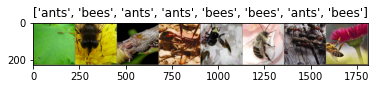

In [98]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)

# Generate one train dataset batch
imgs, cls = next(iter(data_loaders['train']))

# Generate a grid from batch
grid = torchvision.utils.make_grid(imgs)

imageshow(grid, text=[classes[c] for c in cls])

In [99]:
def visualize_predictions(pretrained_model, max_num_imgs=4):
  torch.manual_seed(1)
  was_model_training = pretrained_model.training
  pretrained_model.eval()
  imgs_counter = 0
  fig = plt.figure()

  with torch.no_grad():
      for i, (imgs, labels) in enumerate(data_loaders['val']):
          imgs = imgs.to(device)
          labels = labels.to(device)
          ops = pretrained_model(imgs)
          _, preds = torch.max(ops, 1)
          
          for j in range(imgs.size()[0]):
              imgs_counter += 1
              ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
              ax.axis('off')
              ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[labels[j]]}')
              imageshow(imgs.cpu().data[j])

              if imgs_counter == max_num_imgs:
                  pretrained_model.train(mode=was_model_training)
                  return
      pretrained_model.train(mode=was_model_training)

In [100]:
model_finetune = models.alexnet(pretrained=True)
print(model_finetune.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [101]:
print(model_finetune.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [102]:
# change the last layer from 1000 classes to 2 classes
model_finetune.classifier[6] = nn.Linear(4096, len(classes))

loss_func = nn.CrossEntropyLoss()
optim_finetune = opt.SGD(model_finetune.parameters(), lr=0.0001)

# train (fine-tune) and validate the model
model_finetune = finetune_model(model_finetune, loss_func, optim_finetune, epochs=10)

Epoch number 0/9
train loss in this epoch: 0.8526640680969738, accuracy in this epoch: 0.5040983606557378
val loss in this epoch: 0.7021357740452087, accuracy in this epoch: 0.6013071895424836
Epoch number 1/9
train loss in this epoch: 0.6350726670906192, accuracy in this epoch: 0.639344262295082
val loss in this epoch: 0.5719940301055223, accuracy in this epoch: 0.6993464052287582
Epoch number 2/9
train loss in this epoch: 0.57400737238712, accuracy in this epoch: 0.6926229508196722
val loss in this epoch: 0.48417167725905874, accuracy in this epoch: 0.738562091503268
Epoch number 3/9
train loss in this epoch: 0.4710794560244826, accuracy in this epoch: 0.7745901639344263
val loss in this epoch: 0.43306249574898115, accuracy in this epoch: 0.7843137254901961
Epoch number 4/9
train loss in this epoch: 0.4431549638021188, accuracy in this epoch: 0.8073770491803279
val loss in this epoch: 0.3935988642810996, accuracy in this epoch: 0.8104575163398693
Epoch number 5/9
train loss in this e

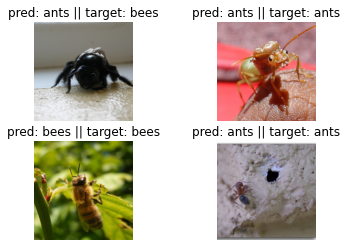

In [103]:
visualize_predictions(model_finetune)